# Fiddle visualization, printing, and codegen

*Please see https://github.com/google/fiddle/blob/main/docs/colabs.md for other colabs.*

Fiddle allows developers to visualize their configuration DAGs in a variety of
ways. These introspection tools can be used to:

*   Modify configuration, e.g. when an experimenter is customizing a model that
    is complex.
*   Dump all configuration values when an experiment is launched, in order to
    create concise summaries of the effective configuration.
*   Debug experimental configuration override code, by printing a history of
    assignments to config values.

In [1]:
!pip install fiddle




import fiddle as fdl
from fiddle import graphviz
from fiddle import printing
from fiddle.codegen import codegen
from fiddle.experimental import visualize
import fiddle.extensions.jax

fiddle.extensions.jax.enable()  # Nicer printout for JAX types; non-essential.

## Running example

Let's consider a dual encoder model, similar to our intro notebook. In this
case, we'll aim to configure a model that has separate continuous encoders for
queries and documents, but shares token embeddings.

In [2]:
from typing import Any, Dict

from flax import linen as nn
import jax
import jax.numpy as jnp


class TokenEmbedder(nn.Module):
  num_embeddings: int
  features: int
  embedding_init: Any
  dtype: Any = jnp.float32  # Activation dtype; params are always float32

  def setup(self):
    self.embedding = self.param(
        'embedding',
        self.embedding_init,
        (self.num_embeddings, self.features),
        jnp.float32,
    )

  def __call__(self, inputs: jnp.ndarray) -> jnp.ndarray:
    return jnp.asarray(self.embedding[inputs], self.dtype)


class SimpleEncoder(nn.Module):
  token_embedder: nn.Module
  output_features: int

  @nn.compact
  def __call__(self, inputs: jnp.ndarray) -> jnp.ndarray:
    embedded = self.token_embedder(inputs)
    return nn.Dense(features=self.output_features)(embedded)


class DualEncoder(nn.Module):
  query_encoder: SimpleEncoder
  document_encoder: SimpleEncoder

  def __call__(self, query, document):
    return jnp.einsum(
        '...h,...h->...',
        self.query_encoder(query),
        self.document_encoder(document),
    )


def base_config() -> fdl.Config[DualEncoder]:
  shared_token_embedder = fdl.Config(
      TokenEmbedder,
      num_embeddings=12,
      features=3,
      embedding_init=fdl.Config(
          nn.initializers.variance_scaling, 1.0, 'fan_in', 'normal',
          out_axis=0))
  return fdl.Config(
      DualEncoder,
      query_encoder=fdl.Config(SimpleEncoder, shared_token_embedder, 12),
      document_encoder=fdl.Config(SimpleEncoder, shared_token_embedder, 12),
  )


# Run the model, just to show that it is a valid Flax module.
model = fdl.build(base_config())
output, variables = model.init_with_output(
    jax.random.PRNGKey(0),
    query=jnp.array([1, 2, 4], jnp.int32),
    document=jnp.array([1, 2, 4], jnp.int32),
)
output

Array([-1.5902882, -2.9393113, -1.2368726], dtype=float32)

## Graphviz rendering

We can visualize this model using the `graphviz.render()` API,

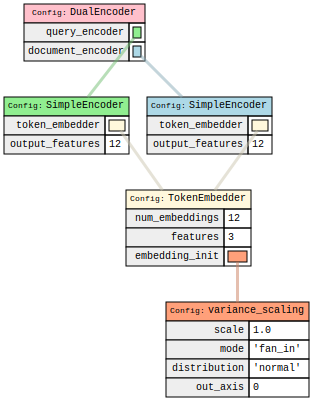

In [3]:
graphviz.render(base_config())

The `TokenEmbedder`'s `dtype` parameter has not been configured, so it is just
using the default defined in the class. If we set it, it will appear in this
visualization,

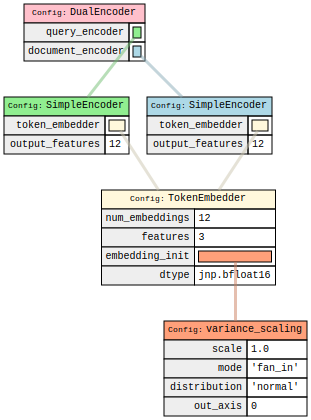

In [4]:
cfg = base_config()
cfg.query_encoder.token_embedder.dtype = jnp.bfloat16
graphviz.render(cfg)

You'll notice that this is nicely rendered as `jnp.bfloat16` instead of its
`repr()` string, `<class 'jax._src.numpy.lax_numpy.bfloat16'>`; this is because
we called `fiddle.extensions.jax.enable()` in the beginning of this colab.
However, these JAX extensions are not necessary for graphviz to work.

### Trimming large graphs

The `visualize` module provides convenient ways to trim large graphs. For
example, let's say that you wanted to print the configuration without the
`document_encoder` details,

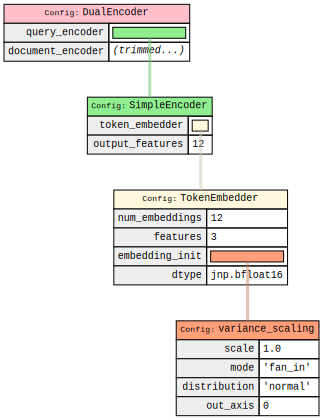

In [5]:
graphviz.render(visualize.trimmed(cfg, [cfg.document_encoder]))

You can also remove nodes that are more than a certain depth by specifying the `max_depth` parameter.

(Technical detail: If a node has multiple paths from the root, then its "depth"
is the minimum path length from the root.)

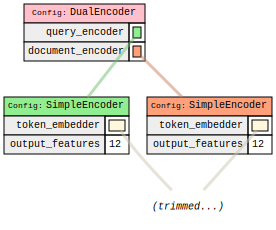

In [6]:
graphviz.render(cfg, max_depth=1)

## Plain text printout

By default, `fdl.Config` objects have a `__str__` representation that gives configured parameters on one line,

In [7]:
print(base_config())

<IPython.core.display.Javascript object>

<Config[DualEncoder(
  query_encoder=<Config[SimpleEncoder(
    token_embedder=<Config[TokenEmbedder(
      num_embeddings=12,
      features=3,
      embedding_init=<Config[variance_scaling(
        scale=1.0,
        mode='fan_in',
        distribution='normal',
        out_axis=0)]>)]>,
    output_features=12)]>,
  document_encoder=<Config[SimpleEncoder(
    token_embedder=<Config[TokenEmbedder(
      num_embeddings=12,
      features=3,
      embedding_init=<Config[variance_scaling(
        scale=1.0,
        mode='fan_in',
        distribution='normal',
        out_axis=0)]>)]>,
    output_features=12)]>)]>


The `printing` library produces `grep`able output, and includes default argument
values. This is very useful when dumping all configuration values before
launching a giant, expensive model training run. Someone evaluating the artifact
later might wonder what `TokenEmbedder`'s dtype is; this will provide it even if
its default value is used.

In [8]:
print(printing.as_str_flattened(base_config()))

query_encoder.token_embedder.num_embeddings: int = 12
query_encoder.token_embedder.features: int = 3
query_encoder.token_embedder.embedding_init.scale: typing.Any = 1.0
query_encoder.token_embedder.embedding_init.mode: typing.Union[typing.Literal['fan_in'], typing.Literal['fan_out'], typing.Literal['fan_avg']] = 'fan_in'
query_encoder.token_embedder.embedding_init.distribution: typing.Union[typing.Literal['truncated_normal'], typing.Literal['normal'], typing.Literal['uniform']] = 'normal'
query_encoder.token_embedder.embedding_init.in_axis: typing.Union[int, typing.Sequence[int]] = <[unset; default: -2]>
query_encoder.token_embedder.embedding_init.out_axis: typing.Union[int, typing.Sequence[int]] = 0
query_encoder.token_embedder.embedding_init.batch_axis: typing.Sequence[int] = <[unset; default: ()]>
query_encoder.token_embedder.embedding_init.dtype: typing.Any = <[unset; default: jnp.float64]>
query_encoder.token_embedder.dtype: typing.Any = <[unset; default: jnp.float32]>
query_encod

### Per-parameter history (aka time-travelling debugging)

For debugging purposes and for tracing when a parameter was set, you can use the `history_per_leaf_parameter()` API to print out historical values from each config. This can be useful in large codebases, for tracking
down what experimental overrides were applied to a configuration.

In the example below, `experiment_config()` overrides `num_embeddings`. You can
see both the current value, and the previous value which `base_config()` set. It
appears twice because the shared object is printed for both the encoder and
decoder.

In [9]:
def experiment_config():
  cfg = base_config()
  cfg.query_encoder.token_embedder.num_embeddings = 40
  return cfg


print(printing.history_per_leaf_parameter(experiment_config()))

__fn_or_cls__ = <class '__main__.DualEncoder'> @ <ipython-input-2-1c737bdff90c>:56:base_config
query_encoder.__fn_or_cls__ = <class '__main__.SimpleEncoder'> @ <ipython-input-2-1c737bdff90c>:58:base_config
query_encoder.token_embedder.__fn_or_cls__ = <class '__main__.TokenEmbedder'> @ <ipython-input-2-1c737bdff90c>:49:base_config
query_encoder.token_embedder.num_embeddings = 40 @ <ipython-input-9-1e867d8d9c8e>:3:experiment_config
  - previously: 12 @ <ipython-input-2-1c737bdff90c>:49:base_config
query_encoder.token_embedder.features = 3 @ <ipython-input-2-1c737bdff90c>:49:base_config
query_encoder.token_embedder.embedding_init.__fn_or_cls__ = <function variance_scaling at 0x7fd277681cf0> @ <ipython-input-2-1c737bdff90c>:53:base_config
query_encoder.token_embedder.embedding_init.scale = 1.0 @ <ipython-input-2-1c737bdff90c>:53:base_config
query_encoder.token_embedder.embedding_init.mode = 'fan_in' @ <ipython-input-2-1c737bdff90c>:53:base_config
query_encoder.token_embedder.embedding_init

## Code generation

Finally, Fiddle provides functionality to generate code for a given
configuration object. This can be useful for materializing a concrete configuration out of factorized configuration code. Such concrete/flattened configurations may be useful for:

 * Ensuring there is configuration that matches a durable artifact like a model
checkpoint.
 * Workflows where a successful experiment becomes a new baseline. Having the baseline less factorized can make it more approachable.

In [10]:
# Note: This is a "Mini AST" node, which can be programmatically modified.
cfg = experiment_config()
cfg.query_encoder.token_embedder.dtype = jnp.bfloat16
generated = codegen.codegen_dot_syntax(cfg)
print("\n".join(generated.lines()))

import fiddle as fdl
from jax.nn import initializers
from jax import numpy as jnp


def build_config():
  shared_variance_scaling = fdl.Config(initializers.variance_scaling)
  shared_variance_scaling.scale = 1.0
  shared_variance_scaling.mode = 'fan_in'
  shared_variance_scaling.distribution = 'normal'
  shared_variance_scaling.out_axis = 0
  
  shared_token_embedder = fdl.Config(TokenEmbedder)
  shared_token_embedder.num_embeddings = 40
  shared_token_embedder.features = 3
  shared_token_embedder.embedding_init = shared_variance_scaling
  shared_token_embedder.dtype = jnp.bfloat16
  
  root = fdl.Config(DualEncoder)
  
  root.query_encoder = fdl.Config(SimpleEncoder)
  root.query_encoder.token_embedder = shared_token_embedder
  root.query_encoder.output_features = 12
  
  root.document_encoder = fdl.Config(SimpleEncoder)
  root.document_encoder.token_embedder = shared_token_embedder
  root.document_encoder.output_features = 12
  
  return root


Sometimes, for larger systems, you'll need to customize how imports are
generated, because the module information extracted from classes reflects where
the class is actually defined, rather than the canonical code used to access it.
Please see the files in `extensions/` for examples of this customization.